## Billion-scale Commodity Embedding for E-commerce Recommendation in Alibaba (EGES)

构建的图节点数: 6
构建的图边数: 9
生成随机游走序列数: 300
示例序列: [0, 4, 3, 4, 1]
使用设备: cuda


100%|██████████| 500/500 [05:12<00:00,  1.60it/s]


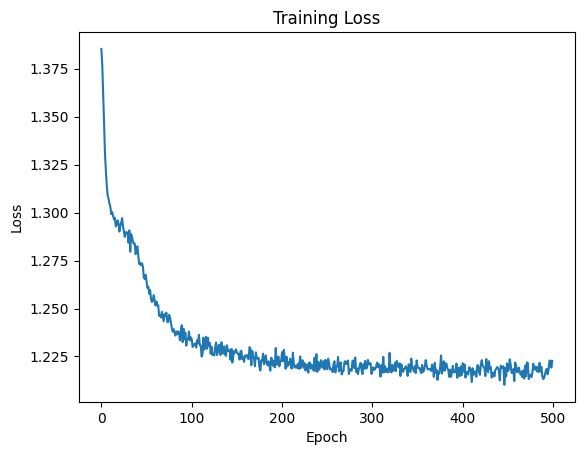


物品属性的权重分析:

物品: iPhone 13
  ID权重: 0.2742
  品牌权重: 0.2641 (Apple)
  类别权重: 0.1967 (手机)
  店铺权重: 0.2650 (Apple旗舰店)

物品: MacBook Air
  ID权重: 0.2341
  品牌权重: 0.2660 (Apple)
  类别权重: 0.2333 (笔记本)
  店铺权重: 0.2666 (Apple旗舰店)

物品: iPad Pro
  ID权重: 0.2539
  品牌权重: 0.2472 (Apple)
  类别权重: 0.2545 (平板)
  店铺权重: 0.2444 (Apple旗舰店)

物品: 华为 P50
  ID权重: 0.2750
  品牌权重: 0.2754 (Huawei)
  类别权重: 0.1716 (手机)
  店铺权重: 0.2780 (华为旗舰店)

物品: 小米充电宝
  ID权重: 0.2466
  品牌权重: 0.2698 (Xiaomi)
  类别权重: 0.2625 (充电设备)
  店铺权重: 0.2212 (小米官方店)

物品: Samsung S22
  ID权重: 0.0023
  品牌权重: 0.0277 (Samsung)
  类别权重: 0.0000 (手机)
  店铺权重: 0.9699 (三星旗舰店)

物品: iPhone 14
  ID权重: 0.3193
  品牌权重: 0.2404 (Apple)
  类别权重: 0.2030 (手机)
  店铺权重: 0.2373 (Apple旗舰店)


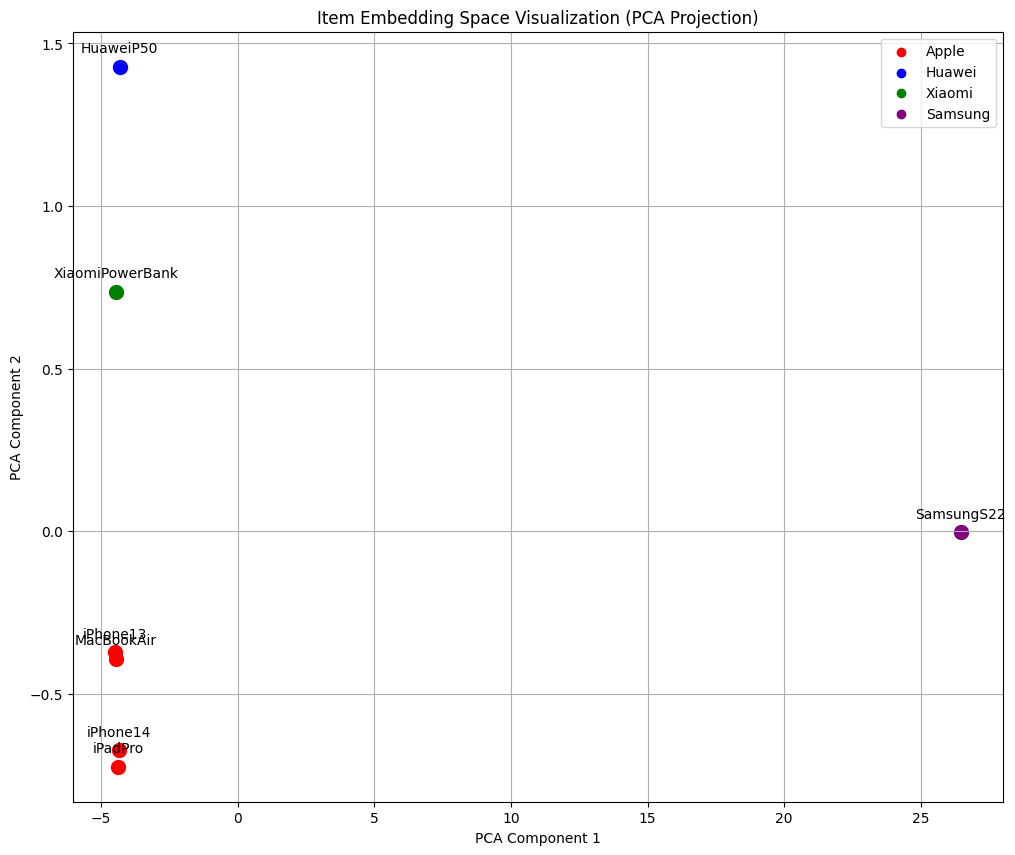


iPhone 13 和 iPhone 14 的相似度: 0.7776


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 1. 创建模拟数据集
class EcommerceDataset:
    def __init__(self):
        # 商品ID和属性
        self.items = {
            0: {"name": "iPhone 13", "brand": "Apple", "category": "手机", "shop": "Apple旗舰店"},
            1: {"name": "MacBook Air", "brand": "Apple", "category": "笔记本", "shop": "Apple旗舰店"},
            2: {"name": "iPad Pro", "brand": "Apple", "category": "平板", "shop": "Apple旗舰店"},
            3: {"name": "华为 P50", "brand": "Huawei", "category": "手机", "shop": "华为旗舰店"},
            4: {"name": "小米充电宝", "brand": "Xiaomi", "category": "充电设备", "shop": "小米官方店"},
            5: {"name": "Samsung S22", "brand": "Samsung", "category": "手机", "shop": "三星旗舰店"},
            6: {"name": "iPhone 14", "brand": "Apple", "category": "手机", "shop": "Apple旗舰店"}  # 冷启动商品
        }
        # 用户行为序列
        self.user_sequences = [
            [0, 1, 4],  # 用户A: iPhone13 -> MacBook Air -> 小米充电宝
            [0, 2],     # 用户B: iPhone13 -> iPad Pro
            [3, 4],     # 用户C: 华为P50 -> 小米充电宝
            [1, 0, 2],  # 用户D: MacBook Air -> iPhone13 -> iPad Pro
            [6, 0],     # 用户E: iPhone14 -> iPhone13
            [6, 2],     # 用户F: iPhone14 -> iPad Pro
            [0, 6],     # 用户G: iPhone13 -> iPhone14
            [2, 6, 1]   # 用户H: iPad Pro -> iPhone14 -> MacBook Air
        ]
        # 创建属性映射
        self.brands = sorted(set(item["brand"] for item in self.items.values()))
        self.categories = sorted(set(item["category"] for item in self.items.values()))
        self.shops = sorted(set(item["shop"] for item in self.items.values()))
        # 属性到索引的映射
        self.brand_to_idx = {brand: idx for idx, brand in enumerate(self.brands)}
        self.category_to_idx = {category: idx for idx, category in enumerate(self.categories)}
        self.shop_to_idx = {shop: idx for idx, shop in enumerate(self.shops)}
        # 构建item属性矩阵
        self.item_attrs = []
        for i in range(len(self.items)):
            item = self.items[i]
            self.item_attrs.append([
                self.brand_to_idx[item["brand"]],
                self.category_to_idx[item["category"]],
                self.shop_to_idx[item["shop"]]
            ])
        self.item_attrs = np.array(self.item_attrs)
    
    def build_item_graph(self, window_size=2):
        """构建item-item共现图"""
        cooccurrence = defaultdict(lambda: defaultdict(int))
        for seq in self.user_sequences:
            for i in range(len(seq)):
                for j in range(i + 1, min(i + window_size + 1, len(seq))):
                    item1, item2 = seq[i], seq[j]
                    # 无向图，双向计数
                    cooccurrence[item1][item2] += 1
                    cooccurrence[item2][item1] += 1
        # 创建networkx图
        self.G = nx.Graph()
        for item1, neighbors in cooccurrence.items():
            for item2, weight in neighbors.items():
                self.G.add_edge(item1, item2, weight=weight)
        return self.G
    
    def weighted_random_walk(self, start_node, walk_length=3):
        """带权随机游走"""
        walk = [start_node]
        current_node = start_node
        for _ in range(walk_length - 1):
            neighbors = list(self.G.neighbors(current_node))
            if not neighbors:
                break
            # 获取边权重
            weights = [self.G[current_node][n]['weight'] for n in neighbors]
            total_weight = sum(weights)
            # 计算转移概率
            probs = [w / total_weight for w in weights]
            # 根据概率选择下一个节点
            next_node = np.random.choice(neighbors, p=probs)
            walk.append(next_node)
            current_node = next_node
        
        return walk
    
    def generate_walks(self, num_walks=5, walk_length=3):
        """为所有节点生成随机游走序列"""
        self.walks = []
        for _ in range(num_walks):
            for node in self.G.nodes():
                walk = self.weighted_random_walk(node, walk_length)
                self.walks.append(walk)
        return self.walks

# 2. 创建自定义Dataset
class WalkDataset(Dataset):
    def __init__(self, walks, window_size=1):
        self.data = []
        for walk in walks:
            for i, center in enumerate(walk):
                # 上下文窗口内的节点作为正样本
                context = []
                start = max(0, i - window_size)
                end = min(len(walk), i + window_size + 1)
                for j in range(start, end):
                    if i != j:  # 排除中心节点自身
                        context.append(walk[j])
                
                # 如果存在上下文，添加到数据集
                if context:
                    # 为每个上下文创建单独的样本
                    for ctx in context:
                        self.data.append((center, ctx))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

# 3. 实现EGES模型
class EGES(nn.Module):
    def __init__(self, num_items, num_brands, num_categories, num_shops, emb_dim=64):
        super(EGES, self).__init__()
        self.emb_dim = emb_dim
        self.num_side_info = 3  # brand, category, shop
        # ID Embedding
        self.id_emb = nn.Embedding(num_items, emb_dim)
        # Side Information Embeddings
        self.brand_emb = nn.Embedding(num_brands, emb_dim)
        self.category_emb = nn.Embedding(num_categories, emb_dim)
        self.shop_emb = nn.Embedding(num_shops, emb_dim)
        # 权重参数 (每个物品的每个属性都有一个权重)
        self.weights = nn.Embedding(num_items, self.num_side_info + 1)  # +1 for ID
        # 初始化
        self.init_embeddings()
    
    def init_embeddings(self):
        """初始化embedding"""
        init_range = 0.5 / self.emb_dim
        for emb in [self.id_emb, self.brand_emb, self.category_emb, self.shop_emb]:
            nn.init.uniform_(emb.weight, -init_range, init_range)
        # 权重初始化为0 (使初始权重相等)
        nn.init.constant_(self.weights.weight, 0)
    
    def aggregate(self, item_ids, attrs):
        """
        带权聚合物品的embedding表示
        item_ids: [batch_size]
        attrs: [batch_size, num_side_info] (brand_idx, category_idx, shop_idx)
        """
        # 获取ID embedding
        id_emb = self.id_emb(item_ids)  # [batch_size, emb_dim]
        # 获取属性embedding
        brand_emb = self.brand_emb(attrs[:, 0])  # [batch_size, emb_dim]
        category_emb = self.category_emb(attrs[:, 1])
        shop_emb = self.shop_emb(attrs[:, 2])   
        # 获取权重参数
        weights = self.weights(item_ids)  # [batch_size, num_side_info + 1]
        # 应用softmax得到归一化权重
        weights = F.softmax(weights, dim=1)  # [batch_size, 4]
        # 将权重拆分为四个部分
        w_id = weights[:, 0].unsqueeze(1)  # [batch_size, 1]
        w_brand = weights[:, 1].unsqueeze(1)
        w_category = weights[:, 2].unsqueeze(1)
        w_shop = weights[:, 3].unsqueeze(1)
        # 加权聚合
        h = w_id * id_emb + w_brand * brand_emb + w_category * category_emb + w_shop * shop_emb
        return h
    
    def forward(self, center_ids, context_ids, neg_ids, attrs):
        """
        center_ids: 中心物品ID [batch_size]
        context_ids: 上下文物品ID [batch_size]
        neg_ids: 负样本物品ID [batch_size, num_negs]
        attrs: 物品属性 [num_items, num_side_info]
        """
        # 获取中心物品的属性
        center_attrs = attrs[center_ids]
        # 计算中心物品的聚合embedding
        center_emb = self.aggregate(center_ids, center_attrs)  # [batch_size, emb_dim]
        # 计算上下文物品的聚合embedding
        context_attrs = attrs[context_ids]
        context_emb = self.aggregate(context_ids, context_attrs)  # [batch_size, emb_dim]
        # 计算负样本物品的聚合embedding
        batch_size, num_negs = neg_ids.shape
        neg_attrs = attrs[neg_ids.view(-1)]  # [batch_size * num_negs, num_side_info]
        neg_emb = self.aggregate(neg_ids.view(-1), neg_attrs)  # [batch_size * num_negs, emb_dim]
        neg_emb = neg_emb.view(batch_size, num_negs, self.emb_dim)  # [batch_size, num_negs, emb_dim]
        # 计算正样本得分 (中心物品和上下文物品的点积)
        pos_score = torch.sum(center_emb * context_emb, dim=1)  # [batch_size]
        pos_score = torch.clamp(pos_score, max=10, min=-10)  # 防止数值过大
        # 计算负样本得分 (中心物品和负样本的点积)
        neg_score = torch.bmm(neg_emb, center_emb.unsqueeze(2)).squeeze(2)  # [batch_size, num_negs]
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        # 计算损失 (负采样损失)
        pos_loss = -F.logsigmoid(pos_score).mean()
        neg_loss = -F.logsigmoid(-neg_score).mean()
        loss = pos_loss + neg_loss
        return loss
    
    def get_item_embeddings(self, item_ids, attrs):
        """获取物品的聚合embedding表示"""
        with torch.no_grad():
            item_attrs = attrs[item_ids]
            return self.aggregate(item_ids, item_attrs)

# 4. 训练函数
def train(model, dataloader, optimizer, device, dataset, num_epochs=50):
    model.train()
    losses = []
    # 将属性矩阵转换为tensor
    attrs = torch.tensor(dataset.item_attrs, dtype=torch.long).to(device)
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0
        for batch in dataloader:
            center_ids, context_ids = batch
            center_ids = center_ids.to(device)
            context_ids = context_ids.to(device)
            # 为每个样本创建负样本
            neg_ids = torch.randint(0, len(dataset.items), (len(center_ids), 5)).to(device)
            optimizer.zero_grad()
            loss = model(center_ids, context_ids, neg_ids, attrs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        # 每10轮输出一次平均损失
        #if (epoch + 1) % 10 == 0:
        #    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    return losses

# 5. 分析学习到的权重
def analyze_weights(model, dataset):
    weights = model.weights.weight.detach().cpu().numpy()
    print("\n物品属性的权重分析:")
    for item_id, item_data in dataset.items.items():
        item_weights = weights[item_id]
        softmax_weights = np.exp(item_weights) / np.sum(np.exp(item_weights))
        print(f"\n物品: {item_data['name']}")
        print(f"  ID权重: {softmax_weights[0]:.4f}")
        print(f"  品牌权重: {softmax_weights[1]:.4f} ({item_data['brand']})")
        print(f"  类别权重: {softmax_weights[2]:.4f} ({item_data['category']})")
        print(f"  店铺权重: {softmax_weights[3]:.4f} ({item_data['shop']})")

# 6. 可视化embedding空间
def visualize_embeddings(model, dataset, device):
    # 获取所有物品的embedding
    item_ids = torch.arange(len(dataset.items)).to(device)
    attrs = torch.tensor(dataset.item_attrs, dtype=torch.long).to(device)
    embeddings = model.get_item_embeddings(item_ids, attrs).cpu().numpy()
    # 使用PCA降维
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    # 使用英文名称
    english_names = {
        "iPhone 13": "iPhone13",
        "MacBook Air": "MacBookAir",
        "iPad Pro": "iPadPro",
        "华为 P50": "HuaweiP50",
        "小米充电宝": "XiaomiPowerBank",
        "Samsung S22": "SamsungS22",
        "iPhone 14": "iPhone14"
    }
    # 绘制
    plt.figure(figsize=(12, 10))
    for i, item_data in enumerate(dataset.items.values()):
        # 按品牌着色
        brand = item_data["brand"]
        color = {"Apple": "red", "Huawei": "blue", "Xiaomi": "green", "Samsung": "purple"}.get(brand, "gray")
        # 使用英文名称
        name = english_names.get(item_data["name"], item_data["name"])
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], c=color, s=100)
        plt.annotate(name, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                     textcoords="offset points", xytext=(0,10), ha='center')
    # 添加图例
    for brand, color in [("Apple", "red"), ("Huawei", "blue"), ("Xiaomi", "green"), ("Samsung", "purple")]:
        plt.scatter([], [], c=color, label=brand)
    plt.title("Item Embedding Space Visualization (PCA Projection)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# 主函数
def main():
    # 创建数据集
    dataset = EcommerceDataset()
    # 构建商品图
    graph = dataset.build_item_graph()
    print("构建的图节点数:", graph.number_of_nodes())
    print("构建的图边数:", graph.number_of_edges())
    # 生成随机游走序列
    walks = dataset.generate_walks(num_walks=50, walk_length=5)
    print(f"生成随机游走序列数: {len(walks)}")
    print("示例序列:", walks[0])
    # 创建数据集
    walk_dataset = WalkDataset(walks, window_size=2)
    dataloader = DataLoader(walk_dataset, batch_size=32, shuffle=True)
    # 创建模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用设备: {device}")
    model = EGES(
        num_items=len(dataset.items),
        num_brands=len(dataset.brands),
        num_categories=len(dataset.categories),
        num_shops=len(dataset.shops),
        emb_dim=64
    ).to(device)
    # 设置优化器
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    # 训练模型
    train(model, dataloader, optimizer, device, dataset, num_epochs=500)
    # 分析学习到的权重
    analyze_weights(model, dataset)
    # 可视化embedding空间
    visualize_embeddings(model, dataset, device)
    # 冷启动分析 - iPhone 14 (ID=6)
    item_ids = torch.tensor([0, 6], dtype=torch.long).to(device)  # iPhone 13 和 iPhone 14
    attrs = torch.tensor(dataset.item_attrs, dtype=torch.long).to(device)
    embeddings = model.get_item_embeddings(item_ids, attrs).cpu().numpy()
    similarity = np.dot(embeddings[0], embeddings[1]) / (
        np.linalg.norm(embeddings[0]) * np.linalg.norm(embeddings[1]))
    print(f"\niPhone 13 和 iPhone 14 的相似度: {similarity:.4f}")

if __name__ == "__main__":
    main()

## Graph Convolutional Neural Networks for Web-Scale Recommender Systems (PinSAGE)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.1 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 48.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Using device: cuda


--2025-07-08 11:31:36--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

     0K .......... .......... .......... .......... ..........  1% 1.05M 4s
    50K .......... .......... .......... .......... ..........  2% 2.11M 3s
   100K .......... .......... .......... .......... ..........  3% 65.0M 2s
   150K .......... .......... .......... .......... ..........  4%  117M 2s
   200K .......... .......... .......... .......... ..........  5% 2.20M 2s
   250K .......... .......... .......... .......... ..........  6%  125M 1s
   300K .......... .......... .......... .......... ..........  7%  199M 1s
   350K .......... .......... .......... .......... ..........  8%  269M 1s
   400K .......... .......... ......

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         
用户数: 943, 物品数: 1682, 边数: 100000


100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


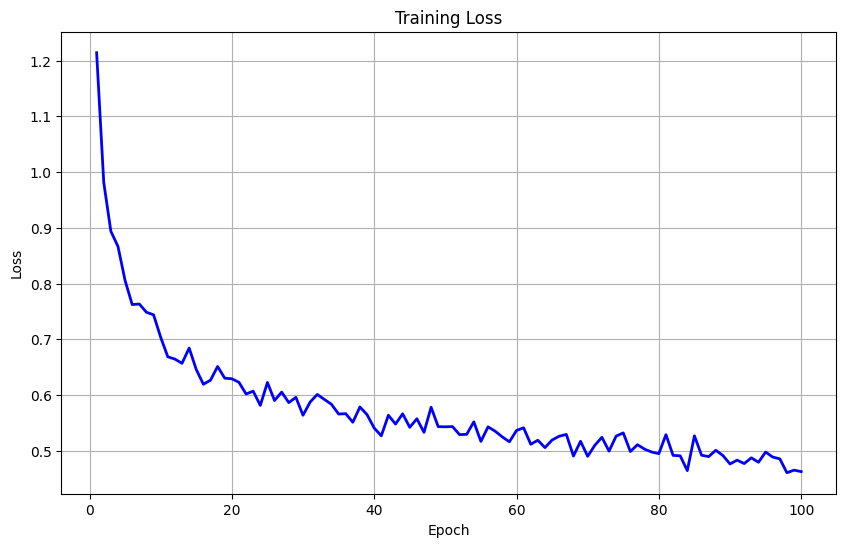

模型和损失历史保存成功

为用户ID=1生成推荐:
推荐物品ID: [1156, 1661, 294, 988, 429, 605, 1616, 948, 1673, 1130]
推荐得分: [8.13958   7.1088986 5.9919734 5.818947  5.598501  5.5606484 5.533398
 5.4752464 5.392829  5.3213234]
推荐结果已保存到'recommendations.txt'


In [2]:
!pip install torch-geometric
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.6.0+cu118.html  # 适配GPU版本
!pip install matplotlib  # 新增：用于绘制损失曲线

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt  # 新增：导入绘图库

# 设置随机种子确保可复现性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# 设备配置 - 优先使用GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. 数据准备 - 使用MovieLens-100k数据集
def load_movielens_data():
    if not os.path.exists('ml-100k/u.data'):
        os.system('wget http://files.grouplens.org/datasets/movielens/ml-100k.zip')
        os.system('unzip ml-100k.zip')
    ratings = pd.read_csv('ml-100k/u.data', sep='\t', header=None, 
                         names=['user_id', 'item_id', 'rating', 'timestamp'])
    data = HeteroData()
    # 用户节点映射
    user_ids = ratings['user_id'].unique()
    user_mapping = {id: idx for idx, id in enumerate(user_ids)}
    data['user'].num_nodes = len(user_ids)
    # 物品节点映射
    item_ids = ratings['item_id'].unique()
    item_mapping = {id: idx for idx, id in enumerate(item_ids)}
    data['item'].num_nodes = len(item_ids)
    # 初始化特征
    data['user'].x = torch.randn(data['user'].num_nodes, 16)
    data['item'].x = torch.randn(data['item'].num_nodes, 32)
    # 用户-物品交互边
    src = [user_mapping[id] for id in ratings['user_id']]
    dst = [item_mapping[id] for id in ratings['item_id']]
    edge_index = torch.tensor([src, dst], dtype=torch.long)
    data['user', 'rates', 'item'].edge_index = edge_index
    # 划分训练集
    num_edges = edge_index.size(1)
    indices = torch.randperm(num_edges)
    train_idx = indices[:int(0.8 * num_edges)]
    train_mask = torch.zeros(num_edges, dtype=torch.bool)
    train_mask[train_idx] = True
    data['user', 'rates', 'item'].train_mask = train_mask
    # 反向边（物品-用户）
    data['item', 'rated_by', 'user'].edge_index = edge_index.flip(0)
    # 预计算用户交互物品
    user_interacted = defaultdict(set)
    for i in range(edge_index.size(1)):
        user_idx = edge_index[0, i].item()
        item_idx = edge_index[1, i].item()
        user_interacted[user_idx].add(item_idx)
    
    return data, user_interacted, user_mapping, item_mapping

# 加载数据并转移到GPU
data, user_interacted, user_mapping, item_mapping = load_movielens_data()
data = data.to(device)  # 转移到GPU
print(f"用户数: {data['user'].num_nodes}, 物品数: {data['item'].num_nodes}, 边数: {data['user', 'rates', 'item'].edge_index.size(1)}")

# 2. 修正后的PinSAGE模型
class PinSAGE(torch.nn.Module):
    def __init__(self, user_feat_dim, item_feat_dim, hidden_channels):
        super().__init__()
        # 特征投影到相同维度
        self.user_proj = nn.Linear(user_feat_dim, hidden_channels)
        self.item_proj = nn.Linear(item_feat_dim, hidden_channels)
        # 图卷积层
        self.user_conv = SAGEConv((hidden_channels, hidden_channels), hidden_channels)
        self.item_conv = SAGEConv((hidden_channels, hidden_channels), hidden_channels)
    
    def forward(self, x_dict):
        # 特征投影
        user_x = self.user_proj(x_dict['user'])
        item_x = self.item_proj(x_dict['item'])
        # 物品卷积
        item_x_updated = self.item_conv(
            (user_x, item_x),
            data['user', 'rates', 'item'].edge_index
        )
        item_x = F.relu(item_x + item_x_updated)
        # 用户卷积
        user_x_updated = self.user_conv(
            (item_x, user_x),
            data['item', 'rated_by', 'user'].edge_index
        )
        user_x = F.relu(user_x + user_x_updated)
        return user_x, item_x
    
    def encode(self):
        with torch.no_grad():
            x_dict = {'user': data['user'].x, 'item': data['item'].x}
            return self.forward(x_dict)
    
    def predict_batch(self, users, items):
        user_emb, item_emb = self.encode()
        return (user_emb[users] * item_emb[items]).sum(dim=1)
    
    def loss(self, users, pos_items, neg_items):
        """修正后的损失函数"""
        user_emb, item_emb = self.forward({'user': data['user'].x, 'item': data['item'].x})
        user_emb = user_emb[users]  # [batch_size, hidden_dim]
        pos_emb = item_emb[pos_items]  # [batch_size, hidden_dim]
        # 处理负样本
        batch_size, num_neg = neg_items.shape
        neg_emb = item_emb[neg_items.view(-1)]  # [batch_size*num_neg, hidden_dim]
        neg_emb = neg_emb.view(batch_size, num_neg, -1)  # [batch_size, num_neg, hidden_dim]
        # 计算正样本得分
        pos_scores = (user_emb * pos_emb).sum(dim=1, keepdim=True)  # [batch_size, 1]
        # 计算负样本得分（每个用户对多个负样本）
        user_emb_expanded = user_emb.unsqueeze(1)  # [batch_size, 1, hidden_dim]
        neg_scores = (user_emb_expanded * neg_emb).sum(dim=2)  # [batch_size, num_neg]
        # 对比损失（每个正样本对应多个负样本）
        loss = F.relu(neg_scores - pos_scores + 1.0).mean()
        return loss

# 3. 负样本生成
def generate_negative_samples(users, num_negatives=5):
    all_items = torch.arange(data['item'].num_nodes, device=device)
    neg_samples = []
    for user in users:
        interacted = user_interacted.get(user.item(), set())
        mask = torch.ones(data['item'].num_nodes, dtype=torch.bool, device=device)
        mask[list(interacted)] = False  # 排除已交互物品
        candidates = all_items[mask]
        if len(candidates) < num_negatives:
            candidates = all_items  # 兜底
        neg = candidates[torch.randperm(len(candidates))[:num_negatives]]
        neg_samples.append(neg)
    return torch.stack(neg_samples)

# 4. 训练函数 - 修改：增加损失记录和绘图功能
def train(model, optimizer, num_epochs=20, batch_size=128):
    model.train()
    train_edge_index = data['user', 'rates', 'item'].edge_index
    train_users = train_edge_index[0, data['user', 'rates', 'item'].train_mask].unique()
    epoch_losses = []  # 新增：记录每个epoch的平均损失
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0
        num_batches = (len(train_users) + batch_size - 1) // batch_size
        perm = torch.randperm(len(train_users), device=device)
        batch_losses = []  # 新增：记录每个batch的损失
        for i in range(num_batches):
            start = i * batch_size
            end = min((i+1)*batch_size, len(train_users))
            batch_users = train_users[perm[start:end]]
            # 正样本：每个用户随机选一个交互过的物品
            pos_items = []
            for u in batch_users:
                mask = (train_edge_index[0] == u) & data['user', 'rates', 'item'].train_mask
                items = train_edge_index[1, mask]
                pos_items.append(items[torch.randint(len(items), (1,))])
            pos_items = torch.cat(pos_items).to(device)
            # 负样本生成
            neg_items = generate_negative_samples(batch_users)
            # 计算损失
            optimizer.zero_grad()
            loss = model.loss(batch_users, pos_items, neg_items)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_losses.append(loss.item())  # 新增：保存当前batch的损失
        # 计算平均损失
        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)
        #print(f"Epoch {epoch+1}, 平均损失: {avg_loss:.4f}")
    # 新增：绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, 'b-', linewidth=2)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('training_loss.png')
    plt.show()
    return epoch_losses  # 返回损失历史

# 5. 推荐函数 
def recommend_items(model, user_id, top_k=10):
    """为指定用户生成推荐物品"""
    model.eval()
    # 获取用户ID对应的内部索引
    user_idx = torch.tensor([user_mapping[user_id]], device=device)
    # 获取所有物品的索引
    all_items = torch.arange(data['item'].num_nodes, device=device)
    # 排除用户已交互的物品
    interacted_items = user_interacted.get(user_idx.item(), set())
    candidate_items = [i for i in range(data['item'].num_nodes) if i not in interacted_items]
    candidate_items = torch.tensor(candidate_items, device=device)
    # 计算用户对候选物品的预测得分
    with torch.no_grad():
        user_emb, item_emb = model.encode()
        user_emb = user_emb[user_idx].expand(len(candidate_items), -1)
        item_emb = item_emb[candidate_items]
        # 计算得分
        scores = (user_emb * item_emb).sum(dim=1)
        # 获取top_k物品
        top_scores, top_indices = scores.topk(top_k)
        top_items = candidate_items[top_indices]
    # 转换回原始物品ID
    original_item_ids = [list(item_mapping.keys())[list(item_mapping.values()).index(i.item())] 
                         for i in top_items]
    
    return original_item_ids, top_scores.cpu().numpy()
# 5. 主函数
if __name__ == "__main__":
    # 初始化模型并转移到GPU
    model = PinSAGE(
        user_feat_dim=data['user'].x.size(1),
        item_feat_dim=data['item'].x.size(1),
        hidden_channels=64
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # 修改：获取损失历史并保存模型
    loss_history = train(model, optimizer, num_epochs=100, batch_size=32)
    # 保存模型和损失历史
    torch.save(model.state_dict(), 'pinsage_gpu_model.pth')
    np.save('training_loss_history.npy', np.array(loss_history))
    print("模型和损失历史保存成功")
    user_id = 1
    if user_id in user_mapping:
        print(f"\n为用户ID={user_id}生成推荐:")
        recommended_items, scores = recommend_items(model, user_id, top_k=10)
        print("推荐物品ID:", recommended_items)
        print("推荐得分:", scores)
        # 保存推荐结果
        with open('recommendations.txt', 'w') as f:
            f.write(f"为用户ID={user_id}的推荐结果:\n")
            for i, (item_id, score) in enumerate(zip(recommended_items, scores)):
                f.write(f"{i+1}. 物品ID: {item_id}, 得分: {score:.4f}\n")
        print("推荐结果已保存到'recommendations.txt'")
    else:
        print(f"用户ID={user_id}不在训练数据中")